<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Variational-Quantum-Deflation-(VQD)" data-toc-modified-id="Variational-Quantum-Deflation-(VQD)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Variational Quantum Deflation (VQD)</a></span><ul class="toc-item"><li><span><a href="#Defining-the-Hamiltonian" data-toc-modified-id="Defining-the-Hamiltonian-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Defining the Hamiltonian</a></span></li><li><span><a href="#Eigenvalues" data-toc-modified-id="Eigenvalues-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Eigenvalues</a></span></li></ul></li><li><span><a href="#Lowest-Eigenvalue" data-toc-modified-id="Lowest-Eigenvalue-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lowest Eigenvalue</a></span><ul class="toc-item"><li><span><a href="#Ansatz" data-toc-modified-id="Ansatz-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ansatz</a></span></li><li><span><a href="#Observables" data-toc-modified-id="Observables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Observables</a></span><ul class="toc-item"><li><span><a href="#Z-Observables" data-toc-modified-id="Z-Observables-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Z Observables</a></span></li><li><span><a href="#X-observables" data-toc-modified-id="X-observables-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>X observables</a></span></li><li><span><a href="#Y-observables" data-toc-modified-id="Y-observables-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Y observables</a></span></li><li><span><a href="#Unit-test" data-toc-modified-id="Unit-test-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Unit test</a></span></li></ul></li><li><span><a href="#Objective-Function" data-toc-modified-id="Objective-Function-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Objective Function</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Optimizer</a></span></li><li><span><a href="#Running" data-toc-modified-id="Running-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Running</a></span></li></ul></li><li><span><a href="#Second-Eigenvalue" data-toc-modified-id="Second-Eigenvalue-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Second Eigenvalue</a></span><ul class="toc-item"><li><span><a href="#Swap-Test" data-toc-modified-id="Swap-Test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Swap Test</a></span><ul class="toc-item"><li><span><a href="#Swap-Test" data-toc-modified-id="Swap-Test-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Swap Test</a></span><ul class="toc-item"><li><span><a href="#Unit-tests" data-toc-modified-id="Unit-tests-3.1.1.1"><span class="toc-item-num">3.1.1.1&nbsp;&nbsp;</span>Unit tests</a></span></li></ul></li><li><span><a href="#Destructive-Swap-Test" data-toc-modified-id="Destructive-Swap-Test-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Destructive Swap Test</a></span></li></ul></li><li><span><a href="#Objective-function-for-the-excited-state" data-toc-modified-id="Objective-function-for-the-excited-state-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Objective function for the excited state</a></span></li><li><span><a href="#Running" data-toc-modified-id="Running-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Running</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Results</a></span></li></ul></li></ul></div>

# Variational Quantum Deflation (VQD)

## Defining the Hamiltonian

The hamiltonian that we want to solve is:

$$
H = \frac{1}{2} \big(ZI + ZZ\big)
$$

In [1]:
import numpy as np
import qiskit
from qiskit.aqua.operators import OperatorBase, ListOp, PrimitiveOp, PauliOp
from qiskit.aqua.operators import I, X, Y, Z
from qiskit.quantum_info import Pauli
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt

In [2]:
# hamiltonian = 0.5*(Z^I) + 0.5*(Z^Z)
hamiltonian = 1/2*((I^Z) + (Z^I) + 2*( (X^X) + (Y^Y)))
print(hamiltonian)

0.5 * SummedOp([
  IZ,
  ZI,
  2.0 * XX,
  2.0 * YY
])


## Eigenvalues

In [3]:
eigenvalues, _ = np.linalg.eigh(hamiltonian.to_matrix())
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-2. -1.  1.  2.]


# Lowest Eigenvalue

## Ansatz

In [4]:
from qiskit.circuit.library import TwoLocal

def _get_ansatz(n_qubits):
    return TwoLocal(n_qubits, ['ry','rz'], 'cx', reps=1)

def get_num_parameters(n_qubits):
    return len(_get_ansatz(n_qubits).parameters)

def get_var_form(params, n_qubits=2):
    """Get an hardware-efficient ansatz for n_qubits
    given parameters.
    """
    
    # Define variational Form
    var_form = _get_ansatz(n_qubits)
    
    # Get Parameters from the variational form
    var_form_params = sorted(var_form.parameters, key=lambda p: p.name)
    
    # Check if the number of parameters is compatible
    assert len(var_form_params) == len(params), "The number of parameters don't match"
    
    # Create a dictionary with the parameters and values
    param_dict = dict(zip(var_form_params, params))
    
    # Assing those values for the ansatz
    wave_function = var_form.assign_parameters(param_dict)
    
    return wave_function

## Observables

### Z Observables

In [181]:
from qiskit import Aer, execute

def _measure_zz_circuit(qc: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    """ Construct the circuit to measure 
    """
    zz_circuit = qc.copy()
    zz_circuit.measure_all()
    
    return zz_circuit

def _clear_counts(count: dict) -> dict:
    
    if '00' not in count:
        count['00'] = 0
    if '01' not in count:
        count['01'] = 0
    if '10' not in count:
        count['10'] = 0
    if '11' not in count:
        count['11'] = 0        
    
    return count

def measure_zz(qc, backend, shots=10000):
    """ Measure the ZZ expectation value for a given circuit.
    """
    zz_circuit = _measure_zz_circuit(qc)

    count = execute(zz_circuit, backend=backend, shots=shots).result().get_counts()
    count = _clear_counts(count)    

    # Get total counts in order to obtain the probability
    total_counts = count['00'] + count['11'] + count['01'] + count['10']
    # Get counts for expected value
    zz_meas = count['00'] + count['11'] - count['01'] - count['10']
    return zz_meas / total_counts

def measure_zi(qc, backend, shots=10000):
    """ Measure the ZI expectation value for a given circuit.
    """
    zi_circuit = _measure_zz_circuit(qc)
    
    count = execute(zi_circuit, backend=backend, shots=shots).result().get_counts()
    count = _clear_counts(count)

    # Get total counts in order to obtain the probability
    total_counts = count['00'] + count['11'] + count['01'] + count['10']
    # Get counts for expected value
    zi_meas = count['00'] - count['11'] + count['01'] - count['10']
    return zi_meas / total_counts

def measure_iz(qc, backend, shots=10000):
    """ Measure the IZ expectation value for a given circuit.
    """
    iz_circuit = _measure_zz_circuit(qc)
    
    count = execute(iz_circuit, backend=backend, shots=shots).result().get_counts()
    count = _clear_counts(count)

    # Get total counts in order to obtain the probability
    total_counts = count['00'] + count['11'] + count['01'] + count['10']
    # Get counts for expected value
    iz_meas = count['00'] - count['11'] - count['01'] + count['10']
    return iz_meas / total_counts

### X observables

In [111]:
def _measure_xx_circuit(qc: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    """ Construct the circuit to measure 
    """
    xx_circuit = qc.copy()
    xx_circuit.h(xx_circuit.qregs[0])
    xx_circuit.measure_all()
    
    return xx_circuit

def measure_xx(qc, backend, shots=10000):
    """ Measure the XX expectation value for a given circuit.
    """
    xx_circuit = _measure_xx_circuit(qc)

    count = execute(xx_circuit, backend=backend, shots=shots).result().get_counts()
    count = _clear_counts(count)    

    # Get total counts in order to obtain the probability
    total_counts = count['00'] + count['11'] + count['01'] + count['10']
    # Get counts for expected value
    xx_meas = count['00'] + count['11'] - count['01'] - count['10']              
    return xx_meas / total_counts

### Y observables

In [115]:
def _measure_yy_circuit(qc: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    """ Construct the circuit to measure 
    """
    
    yy_meas = qc.copy()
    yy_meas.barrier(range(2))
    yy_meas.sdg(range(2))    
    yy_meas.h(range(2))    
    yy_meas.measure_all()
    return yy_meas
    

def measure_yy(qc, backend, shots=10000):
    """ Measure the YY expectation value for a given circuit.
    """
    yy_circuit = _measure_yy_circuit(qc)

    count = execute(yy_circuit, backend=backend, shots=shots).result().get_counts()
    count = _clear_counts(count)    

    # Get total counts in order to obtain the probability
    total_counts = count['00'] + count['11'] + count['01'] + count['10']
    # Get counts for expected value
    xx_meas = count['00'] + count['11'] - count['01'] - count['10']              
    return xx_meas / total_counts

### Unit test

In [128]:
import unittest

class TestStringMethods(unittest.TestCase): 
    def setUp(self):
        # Simulator
        self.backend = Aer.get_backend("qasm_simulator")
        
        # ZZ expectation value of 1
        self.qcZ = qiskit.QuantumCircuit(2)        
        
        # XX expectation value of 1
        self.qcX = qiskit.QuantumCircuit(2)        
        self.qcX.h(range(2))
        
        # YY expectation value of 1
        self.qcY = qiskit.QuantumCircuit(2)        
        self.qcY.h(range(2))
        self.qcY.s(range(2))
        
        
    def test_ZZ(self): 
        want = 1.
        got = measure_zz(self.qcZ, self.backend)
        decimalPlace = 2
        message = "ZZ measurement not working for state Zero^Zero."
        self.assertAlmostEqual(want, got, decimalPlace, message)
    
    def test_XX(self): 
        want = 1.
        got = measure_xx(self.qcX, self.backend)
        decimalPlace = 2
        message = "XX measurement not working for state Plus^Plus."
        self.assertAlmostEqual(want, got, decimalPlace, message)
    
    def test_YY(self): 
        want = 1.
        got = measure_yy(self.qcY, self.backend)
        decimalPlace = 2
        message = "YY measurement not working for state iPlus^iPlus."
        self.assertAlmostEqual(want, got, decimalPlace, message)

unittest.main(argv=[''], verbosity=2, exit=False);

test_XX (__main__.TestStringMethods) ... ok
test_YY (__main__.TestStringMethods) ... ok
test_ZZ (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.169s

OK


## Objective Function

In [9]:
from Observables import *

def get_hamiltonian(qc, backend, num_shots):
        # Hamiltonian BCS
    hamiltonian = .5*(measure_iz(qc, backend, num_shots) + measure_zi(qc, backend, num_shots)
                      + 2*(measure_xx(qc, backend, num_shots) + measure_yy(qc, backend, num_shots)))
#     hamiltonian = 0.5*(measure_zi(qc, backend, num_shots) + measure_zz(qc, backend, num_shots))
    return hamiltonian

In [10]:
def objective_function(params):
    
    # Parameters
    backend = Aer.get_backend("qasm_simulator")
    NUM_SHOTS = 10000
    n_qubits = 2
    
    # Define Ansatz
    qc = get_var_form(params, n_qubits)
    
    # Hamiltonian
    hamiltonian = get_hamiltonian(qc, backend, NUM_SHOTS)
    
    # Get the cost function
    cost = hamiltonian
    
    return cost

## Optimizer

In [11]:
from qiskit.aqua.components.optimizers import COBYLA, NELDER_MEAD, SLSQP

optimizer = COBYLA(maxiter=1000, disp=False, rhobeg=1.0, 
                   tol=None)

# optimizer = NELDER_MEAD(maxiter=1000, maxfev=1000, disp=False, 
#                         xatol=0.0001, tol=None, adaptive=True)

# optimizer = SLSQP(maxiter=100, disp=False, 
#                   ftol=1e-06, tol=None)

## Running

Energy obtained: -1.8984


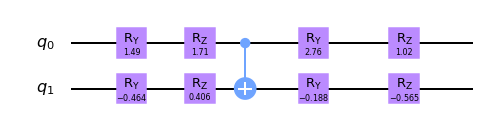

In [12]:
# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_qubits = 2
n_parameters = get_num_parameters(n_qubits)

params = np.random.rand(n_parameters)

optimal_params, energy_gs, n_iters = optimizer.optimize(num_vars=n_parameters, 
                                                        objective_function=objective_function, 
                                                        initial_point=params)

# Obtain the output distribution using the final parameters
ground_state = get_var_form(optimal_params)
print(f"Energy obtained: {energy_gs}")
ground_state.draw('mpl')

# Second Eigenvalue

## Swap Test

### Swap Test

In [132]:
import qiskit
from qiskit import QuantumCircuit

def swap_test_circuit(qc1: qiskit.QuantumCircuit, qc2: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    """ Construct the SWAP test circuit given two circuits.

    Args:
        qc1(qiskit.QuantumCircuit): Quantum circuit for the 
        first state.
        qc2(qiskit.QuantumCircuit): Quantum circuit for the 
        second state.
    Output:
        (qiskit.QuantumCircuit): swap test circuit.
    """
    # Helper variables
    n_total = qc1.num_qubits + qc2.num_qubits
    range_qc1 = [i + 1 for i in range(qc1.num_qubits)]
    range_qc2 = [i + qc1.num_qubits + 1 for i in range(qc2.num_qubits)]

    # Constructing the SWAP test circuit
    qc_swap = QuantumCircuit(n_total + 1, 1)
    qc_swap.append(qc1, range_qc1)
    qc_swap.append(qc2, range_qc2)
    
    # Swap Test
    qc_swap.h(0)
    for index, qubit in enumerate(range_qc1):
        qc_swap.cswap(0, qubit, range_qc2[index] )
    qc_swap.h(0)
    
    # Measurement on the auxiliary qubit
    qc_swap.measure(0,0)
    return qc_swap

In [215]:
def measure_swap_test(qc1: qiskit.QuantumCircuit, qc2: qiskit.QuantumCircuit,
                     backend: qiskit.providers.aer.backends,
                     num_shots: int=10000) -> float:
    """ Returns the fidelity from a SWAP test.
    """
    swap_circuit = swap_test_circuit(qc1, qc2)

    count = execute(swap_circuit, backend=backend, shots=num_shots).result().get_counts()
    
    if '0' not in count:
        count['0'] = 0
    if '1' not in count:
        count['1'] = 0

    total_counts = count['0'] + count['1'] 
    fid_meas = count['0']
    p_0 = fid_meas / total_counts
    return 2*(p_0 - 1/2)

#### Unit tests

In [220]:
import unittest
from qiskit import QuantumCircuit, Aer

class TestStringMethods(unittest.TestCase): 
    def setUp(self):
        self.qc1 = QuantumCircuit(1)
        self.qc1.x(0)
        self.qc2 = QuantumCircuit(1)
        self.backend = Aer.get_backend("qasm_simulator")
    
    def test_01states(self): 
        want = 0.
        got = measure_swap_test(self.qc1, self.qc2, self.backend)
        decimalPlace = 1
        message = "Swap test not working for states 0 and 1."
        self.assertAlmostEqual(want, got, decimalPlace, message) 
    
    def test_00states(self): 
        want = 1.
        got = measure_swap_test(self.qc2, self.qc2, self.backend)
        decimalPlace = 2
        message = "Swap test not working for states 0 and 0."
        self.assertAlmostEqual(want, got, decimalPlace, message)
    
    def test_11states(self): 
        want = 1.
        got = measure_swap_test(self.qc1, self.qc1, self.backend)
        decimalPlace = 2
        message = "Swap test not working for states 1 and 1."
        self.assertAlmostEqual(want, got, decimalPlace, message)

unittest.main(argv=[''], verbosity=2, exit=False);

test_00states (__main__.TestStringMethods) ... ok
test_01states (__main__.TestStringMethods) ... ok
test_11states (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.146s

OK


In [196]:
import unittest

unittest.assertAlmostEqual(0.5, measure_swap_test(qc1,qc2, backend))

AttributeError: module 'unittest' has no attribute 'assertAlmostEqual'

In [195]:
qc1 = QuantumCircuit(1)
qc1.x(0)
qc2 = QuantumCircuit(1)
measure_swap_test(qc1, qc2, backend)

0.5017

In [168]:
measure_swap_test(ground_state, ground_state, backend)

1.0

### Destructive Swap Test

In [102]:
import qiskit
from qiskit import QuantumCircuit

def dswap_test_circuit(qc1: qiskit.QuantumCircuit, qc2: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    """ Construct the destructive SWAP test circuit
    given two circuits.

    Args:
        qc1(qiskit.QuantumCircuit): Quantum circuit for the 
        first state.
        qc2(qiskit.QuantumCircuit): Quantum circuit for the 
        second state.
    Output:
        (qiskit.QuantumCircuit): destructive swap test circuit.
    """
    # Helper variables
    n_total = qc1.num_qubits + qc2.num_qubits
    range_qc1 = [i for i in range(qc1.num_qubits)]
    range_qc2 = [i + qc1.num_qubits for i in range(qc2.num_qubits)]

    # Constructing the Destructive SWAP TEST
    qc_swap = QuantumCircuit(n_total)
    qc_swap.append(qc1, range_qc1)
    qc_swap.append(qc2, range_qc2)

    for index, qubit in enumerate(range_qc1):    
        qc_swap.cx(qubit,range_qc2[index])

    # Haddamard in the first state
    qc_swap.h(range_qc1)
    qc_swap.measure_all()

    return qc_swap

In [103]:
qc = get_var_form([0]*n_parameters)
dswap_circuit = dswap_test_circuit(qc, ground_state)

In [104]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

count = execute(dswap_circuit, backend, shots=NUM_SHOTS).result().get_counts()
print(count)

{'1000': 2530, '1001': 2508, '1010': 2426, '1011': 2508, '1100': 10, '1101': 5, '1110': 6, '1111': 7}


## Objective function for the excited state

In [14]:
from SWAPTest import measure_swap_test

def objective_function_es(params):
    
    # Parameters
    backend = Aer.get_backend("qasm_simulator")
    NUM_SHOTS = 10000
    BETA = 1.
    
    # Define Ansatz
    qc = get_var_form(params)
    
    # Hamiltonian
    hamiltonian = get_hamiltonian(qc, backend, NUM_SHOTS)
    
    # Swap Test
    fidelity = measure_swap_test(qc, ground_state, backend)
    
    # Get the cost function
    cost = hamiltonian + BETA*fidelity
    
    return cost

## Running

Energy obtained: -0.9874


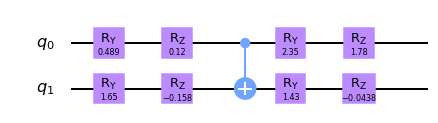

In [15]:
# Create the initial parameters
params = np.random.rand(n_parameters)

optimal_params, energy_es, n_iters = optimizer.optimize(num_vars=n_parameters, 
                                                        objective_function=objective_function_es, 
                                                        initial_point=params)

# Obtain the output state
excited_state = get_var_form(optimal_params)
print(f"Energy obtained: {energy_es}")
excited_state.draw('mpl')

In [17]:
backend = Aer.get_backend("qasm_simulator")
print(f"Fidelity between the Ground state and the Excited state {measure_swap_test(excited_state, ground_state, backend)}")

Fidelity between the Ground state and the Excited state 0.0029999999999998916


## Results

In [18]:
print("Energies")
print(f"Ground State\nExpected: {eigenvalues[0]}  |  Got: {np.round(energy_gs,4)}")
print(f"Ground State\nExpected: {eigenvalues[1]}  |  Got: {np.round(energy_es,4)}")

Energies
Ground State
Expected: -2.0  |  Got: -1.8984
Ground State
Expected: -1.0  |  Got: -0.9874
